In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, f1_score, accuracy_score, roc_auc_score
from watermark import watermark

# encoders
from sklearn.feature_extraction.text import HashingVectorizer

# tokenizers
from nltk.tokenize import wordpunct_tokenize, WhitespaceTokenizer
whitespace_tokenize = WhitespaceTokenizer().tokenize

# modeling
import lightning as L
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.lite.utilities.seed import seed_everything

# import random forest, xgboost, and logistic regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from src.models import *
from src.lit_utils import LitProgressBar
from src.preprocessors import CommandTokenizer, OneHotCustomVectorizer
from src.data_utils import create_dataloader

from typing import List
from torch.utils.data import DataLoader

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_tpr_at_fpr(predicted_logits, true_labels, fprNeeded=1e-4):
    if isinstance(predicted_logits, torch.Tensor):
        predicted_probs = torch.sigmoid(predicted_logits).cpu().detach().numpy()
    else:
        predicted_probs = sigmoid(predicted_logits)
    
    if isinstance(true_labels, torch.Tensor):
        true_labels = true_labels.cpu().detach().numpy()
    
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    if all(np.isnan(fpr)):
        return np.nan#, np.nan
    else:
        tpr_at_fpr = tpr[fpr <= fprNeeded][-1]
        #threshold_at_fpr = thresholds[fpr <= fprNeeded][-1]
        return tpr_at_fpr#, threshold_at_fpr


def commands_to_loader(cmd: List[str], tokenizer: CommandTokenizer, y: np.ndarray = None) -> DataLoader:
    """Convert a list of commands to a DataLoader."""
    tokens = tokenizer.tokenize(cmd)
    ints = tokenizer.encode(tokens)
    padded = tokenizer.pad(ints, MAX_LEN)
    if y is None:
        loader = create_dataloader(padded, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
    else:
        loader = create_dataloader(padded, y, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
    return loader


def load_data():
    train_base_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/train_baseline.parquet/')) if x.endswith('.parquet')][0]
    test_base_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/test_baseline.parquet/')) if x.endswith('.parquet')][0]
    train_rvrs_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/train_rvrs.parquet/')) if x.endswith('.parquet')][0]
    test_rvrs_parquet_file = [x for x in os.listdir(os.path.join(ROOT,'data/test_rvrs.parquet/')) if x.endswith('.parquet')][0]

    # load as dataframes
    train_baseline_df = pd.read_parquet(os.path.join(ROOT,'data/train_baseline.parquet/', train_base_parquet_file))
    test_baseline_df = pd.read_parquet(os.path.join(ROOT,'data/test_baseline.parquet/', test_base_parquet_file))
    train_malicious_df = pd.read_parquet(os.path.join(ROOT,'data/train_rvrs.parquet/', train_rvrs_parquet_file))
    test_malicious_df = pd.read_parquet(os.path.join(ROOT,'data/test_rvrs.parquet/', test_rvrs_parquet_file))

    X_train_non_shuffled = train_baseline_df['cmd'].values.tolist() + train_malicious_df['cmd'].values.tolist()
    y_train = np.array([0] * len(train_baseline_df) + [1] * len(train_malicious_df), dtype=np.int8)
    X_train_cmds, y_train = shuffle(X_train_non_shuffled, y_train, random_state=SEED)

    X_test_non_shuffled = test_baseline_df['cmd'].values.tolist() + test_malicious_df['cmd'].values.tolist()
    y_test = np.array([0] * len(test_baseline_df) + [1] * len(test_malicious_df), dtype=np.int8)
    X_test_cmds, y_test = shuffle(X_test_non_shuffled, y_test, random_state=SEED)

    # ===========================================
    # DATASET LIMITS FOR TESTING
    # ===========================================
    X_train_cmds = X_train_cmds[:LIMIT]
    y_train = y_train[:LIMIT]
    
    X_test_cmds = X_test_cmds[:LIMIT]
    y_test = y_test[:LIMIT]

    return X_train_cmds, y_train, X_test_cmds, y_test

def configure_trainer():
    """Configure the PyTorch Lightning Trainer."""

    trainer = L.Trainer(
        num_sanity_val_steps=0,
        max_epochs=1,
        accelerator="gpu",
        devices=1,
        callbacks=[LitProgressBar()],
        logger=TensorBoardLogger("logs_temp", name="my_model"),
        val_check_interval=0.5,
        log_every_n_steps=10,
    )
    return trainer


def load_lit_model(model_file, pytorch_model, name, log_folder):
    lightning_model = PyTorchLightningModel.load_from_checkpoint(checkpoint_path=model_file, model=pytorch_model)
    trainer = configure_trainer()
    return trainer, lightning_model

SEED = 33

VOCAB_SIZE = 4096
EMBEDDED_DIM = 64
MAX_LEN = 128
BATCH_SIZE = 1024
DROPOUT = 0.5
LOGS_FOLDER = "logs_models"
LIMIT = None
DATALOADER_WORKERS = 4


print(watermark(packages="torch,lightning,sklearn", python=True))
print(f"[!] Script start time: {time.ctime()}")

TOKENIZER = wordpunct_tokenize
seed_everything(SEED)

# ===========================================
# LOADING DATA
# ===========================================
ROOT = os.path.dirname(os.path.abspath("__file__"))
X_train_cmds, y_train, X_test_cmds, y_test = load_data()
print(f"Sizes of train and test sets: {len(X_train_cmds)}, {len(X_test_cmds)}")

# =============================================
# PREPING DATA
# =============================================
tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE)

# ========== EMBEDDING ==========
vocab_file = os.path.join(LOGS_FOLDER, f"wordpunct_vocab_{VOCAB_SIZE}.json")
if os.path.exists(vocab_file):
    print("[*] Loading vocab...")
    tokenizer.load_vocab(vocab_file)
else:
    print("[*] Building vocab and encoding...")
    X_train_tokens = tokenizer.tokenize(X_train_cmds)
    tokenizer.build_vocab(X_train_tokens)
    tokenizer.dump_vocab(vocab_file)

# creating dataloaders
# X_train_loader = commands_to_loader(X_train_cmds, tokenizer, y_train)
X_test_loader = commands_to_loader(X_test_cmds, tokenizer, y_test)

# ========== MIN-HASH TABULAR ENCODING ==========
minhash_vectorizer_file = os.path.join(LOGS_FOLDER, f"minhash_vectorizer_{VOCAB_SIZE}.pkl")
if os.path.exists(minhash_vectorizer_file):
    print("[*] Loading MinHash vectorizer...")
    minhash = pickle.load(open(minhash_vectorizer_file, "rb"))
else:
    minhash = HashingVectorizer(n_features=VOCAB_SIZE, tokenizer=TOKENIZER, token_pattern=None)
    print("[*] Fitting MinHash encoder...")
    minhash.fit(X_train_cmds)
    
    with open(minhash_vectorizer_file, "wb") as f:
        pickle.dump(minhash, f)

# X_train_minhash = minhash.transform(X_train_cmds)
X_test_minhash = minhash.transform(X_test_cmds)

# ========== ONE-HOT TABULAR ENCODING ===========
oh_vectorizer_file = os.path.join(LOGS_FOLDER, f"onehot_vectorizer_{VOCAB_SIZE}.pkl")
if os.path.exists(oh_vectorizer_file):
    print("[*] Loading One-Hot vectorizer...")
    oh = pickle.load(open(oh_vectorizer_file, "rb"))
else:
    oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
    print("[*] Fitting One-Hot encoder...")
    oh.fit(X_train_cmds)

    with open(oh_vectorizer_file, "wb") as f:
        pickle.dump(oh, f)

# X_train_onehot = oh.transform(X_train_cmds)
X_test_onehot = oh.transform(X_test_cmds)

# =============================================
# DEFINING MODELS
# =============================================
print(f"[*] Defining models...")

# sequence models
mlp_seq_model = SimpleMLPWithEmbedding(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDED_DIM, output_dim=1, hidden_dim=[256, 64, 32], use_positional_encoding=False, max_len=MAX_LEN, dropout=DROPOUT) # 297 K params
cnn_model = CNN1DGroupedModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, num_channels=32, kernel_sizes=[2, 3, 4, 5], mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 301 K params
lstm_model = BiLSTMModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, hidden_dim=32, mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 318 K params
cnn_lstm_model = CNN1D_BiLSTM_Model(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, num_channels=32, kernel_size=3, lstm_hidden_dim=32, mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 316 K params
mean_transformer_model = MeanTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) # 335 K params
cls_transformer_model = CLSTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) #  335 K params
attpool_transformer_model = AttentionPoolingTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) #  335 K params
neurlux = NeurLuxModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, max_len=MAX_LEN, hidden_dim=32, output_dim=1, dropout=DROPOUT) # 402 K params

# tabular models
rf_model_minhash = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
xgb_model_minhash = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)
log_reg_minhash = LogisticRegression(random_state=SEED)
mlp_tab_model_minhash = SimpleMLP(input_dim=VOCAB_SIZE, output_dim=1, hidden_dim=[64, 32], dropout=DROPOUT) # 264 K params
rf_model_onehot = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=SEED)
xgb_model_onehot = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)
log_reg_onehot = LogisticRegression(random_state=SEED)
mlp_tab_model_onehot = SimpleMLP(input_dim=VOCAB_SIZE, output_dim=1, hidden_dim=[64, 32], dropout=DROPOUT) # 264 K params

models = {
    "_tabular_mlp_minhash": mlp_tab_model_minhash,
    "_tabular_rf_minhash": rf_model_minhash,
    "_tabular_xgb_minhash": xgb_model_minhash,
    "_tabular_log_reg_minhash": log_reg_minhash,
    "_tabular_mlp_onehot": mlp_tab_model_onehot,
    "_tabular_rf_onehot": rf_model_onehot,
    "_tabular_xgb_onehot": xgb_model_onehot,
    "_tabular_log_reg_onehot": log_reg_onehot,
    "mlp_seq": mlp_seq_model,
    "attpool_transformer": attpool_transformer_model,
    "cls_transformer": cls_transformer_model,
    "mean_transformer": mean_transformer_model,
    "neurlux": neurlux,
    "cnn": cnn_model,
    "lstm": lstm_model,
    "cnn_lstm": cnn_lstm_model,
}

INFO: Global seed set to 33
INFO:lightning.lite.utilities.seed:Global seed set to 33


Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.11.0

torch    : 2.0.1+cu117
lightning: 1.8.6
sklearn  : 0.0.post1

[!] Script start time: Mon Aug 21 19:08:12 2023
Sizes of train and test sets: 533014, 470129
[*] Loading vocab...
[*] Loading MinHash vectorizer...
[*] Loading One-Hot vectorizer...
[*] Defining models...


In [31]:
y_preds_pickle = os.path.join(LOGS_FOLDER, "y_preds.pickle")
if os.path.exists(y_preds_pickle):
    print("[*] Loading predictions...")
    with open(y_preds_pickle, "rb") as f:
        y_preds = pickle.load(f)
else:
    y_preds = {}

for name, model in models.items():
    if name in y_preds:
        print(f"[*] Model {name} already predicted")
        continue

    if name.startswith("_tabular") and "mlp" not in name:
        model_file = os.path.join(LOGS_FOLDER, name, "model.pkl")
        print(f"[*] Loading {name} from {model_file}...")
        with open(model_file, "rb") as f:
            model = pickle.load(f)
        
        preprocessor = name.split("_")[-1]
        assert preprocessor in ["onehot", "minhash"]

        if preprocessor == "onehot":
            # x_train = X_train_onehot
            x_test = X_test_onehot
        
        elif preprocessor == "minhash":
            # x_train = X_train_minhash
            x_test = X_test_minhash

        print(f"[*] Predicting with {name}...")
        y_test_preds = model.predict_proba(x_test)[:,1]
        y_preds[name] = y_test_preds
    
    else:    
        if "tabular" in name:
            preprocessor = name.split("_")[-1]
            assert preprocessor in ["onehot", "minhash"]

            if preprocessor == "onehot":
                # x_train = X_train_onehot
                x_test = X_test_onehot
            
            elif preprocessor == "minhash":
                # x_train = X_train_minhash
                x_test = X_test_minhash

            # train_loader = create_dataloader(x_train, y_train, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
            test_loader = create_dataloader(x_test, y_test, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
        
        else:
            # train_loader = X_train_loader
            test_loader = X_test_loader
        
        chkp_folder = os.path.join(LOGS_FOLDER, f"{name}_csv", "version_0", "checkpoints")
        if not os.path.exists(chkp_folder):
            print(f"Model {name} not trained yet")

        best_model = [x for x in os.listdir(os.path.join(LOGS_FOLDER, f"{name}_csv", "version_0", "checkpoints")) if x.startswith("epoch")][0]
        best_model = os.path.join(chkp_folder, best_model)
        print("Best model: ", best_model)
        trainer, lightning_model = load_lit_model(best_model, model, name, LOGS_FOLDER)
        y_pred_proba = trainer.predict(lightning_model, test_loader, return_predictions=True)
        y_preds[name] = y_pred_proba

with open(y_preds_pickle, "wb") as f:
    pickle.dump(y_preds, f)


[*] Loading predictions...
[*] Model _tabular_mlp_minhash already predicted
[*] Loading _tabular_rf_minhash from logs_models\_tabular_rf_minhash\model.pkl...
[*] Predicting with _tabular_rf_minhash...
[*] Loading _tabular_xgb_minhash from logs_models\_tabular_xgb_minhash\model.pkl...
[*] Predicting with _tabular_xgb_minhash...
[*] Loading _tabular_log_reg_minhash from logs_models\_tabular_log_reg_minhash\model.pkl...
[*] Predicting with _tabular_log_reg_minhash...
[*] Model _tabular_mlp_onehot already predicted
[*] Loading _tabular_rf_onehot from logs_models\_tabular_rf_onehot\model.pkl...
[*] Predicting with _tabular_rf_onehot...
[*] Loading _tabular_xgb_onehot from logs_models\_tabular_xgb_onehot\model.pkl...
[*] Predicting with _tabular_xgb_onehot...
[*] Loading _tabular_log_reg_onehot from logs_models\_tabular_log_reg_onehot\model.pkl...
[*] Predicting with _tabular_log_reg_onehot...
[*] Model mlp_seq already predicted
[*] Model attpool_transformer already predicted
[*] Model cls_t

Working on model:  _tabular_mlp_minhash
Working on model:  _tabular_mlp_onehot
Working on model:  mlp_seq
Working on model:  attpool_transformer
Working on model:  cls_transformer
Working on model:  mean_transformer
Working on model:  neurlux
Working on model:  cnn
Working on model:  lstm
Working on model:  cnn_lstm
Working on model:  _tabular_rf_minhash
Working on model:  _tabular_xgb_minhash
Working on model:  _tabular_log_reg_minhash
Working on model:  _tabular_rf_onehot
Working on model:  _tabular_xgb_onehot
Working on model:  _tabular_log_reg_onehot


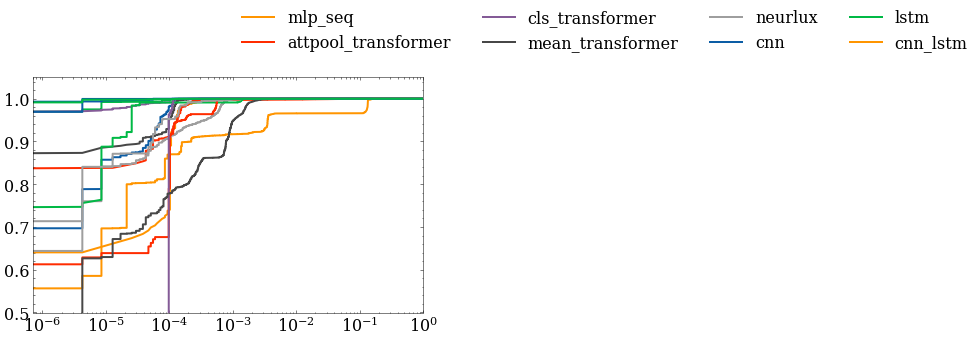

In [45]:
import scienceplots
import matplotlib.pyplot as plt
from collections import defaultdict
from src.plots import set_size, plot_roc_curve

# Setup plotting
plt.style.reload_library()
FONTSIZE = 16
plt.style.use(['science', 'no-latex'])
plt.rcParams.update({'xtick.labelsize': FONTSIZE,
                     'ytick.labelsize': FONTSIZE,
                     # legend fontsize
                    'legend.fontsize': FONTSIZE,
                     'axes.titlesize': 20,
                     })


fig, ax = plt.subplots(1, 1, figsize=set_size())

to_skip = []
for name, y_pred_proba_raw in y_preds.items():
    if name in to_skip:
        continue
    print("Working on model: ", name)
    if isinstance(y_pred_proba_raw, list):
        y_pred_proba = torch.sigmoid(torch.cat(y_pred_proba_raw, dim=0)).numpy().squeeze()
    else:
        y_pred_proba = y_pred_proba_raw
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plot_roc_curve(fpr, tpr, None, model_name=name, ax=ax, semilogx=True, xlim=[0.7e-6,1], ylim=[0.5,1.05])

# get legend handles
# handles, labels = ax.get_legend_handles_labels()
# new_labels = labels
# new_handles = handles # [handles[1], handles[3], handles[2], handles[0], ...]
# ax.legend(new_handles, new_labels, loc='lower right', ncol=2, bbox_to_anchor=(1, 1.05), fontsize=FONTSIZE)
ax.legend(ncol=4, bbox_to_anchor=(0.5, 1.05), fontsize=FONTSIZE)

# ax.set_ylabel("True Positive Rate", fontsize=FONTSIZE)
# ax.set_xlabel("False Positive Rate", fontsize=FONTSIZE)
# plt.savefig(os.path.join("img", "roc_model_ablation.pdf"), dpi=300, bbox_inches='tight')